## Eric Ruiz Sanchez

This project intends to predict the energy usage of a steel producing factory. The dataset contains values that include date and time, energy, emissions and power factors among others.

Additional information will be included in the text file inside the zip file. For more information on the dataset please visit: https://archive.ics.uci.edu/ml/datasets/Steel+Industry+Energy+Consumption+Dataset

### Load python libraries

In [1]:
#Import python libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt 
import itertools

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, SGDRegressor, LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier, AdaBoostRegressor, BaggingClassifier
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from lightgbm import LGBMRegressor

In [2]:
#Load the data
df = pd.read_csv('datasets/Steel_industry_data.csv')

### Peek at the data and get summary statistics

In [3]:
#First 10 rows
df.head(10)

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load
5,01/01/2018 01:30,3.28,3.56,0.0,0.0,67.76,100.0,5400,Weekday,Monday,Light_Load
6,01/01/2018 01:45,3.60,4.14,0.0,0.0,65.62,100.0,6300,Weekday,Monday,Light_Load
7,01/01/2018 02:00,3.60,4.28,0.0,0.0,64.37,100.0,7200,Weekday,Monday,Light_Load
8,01/01/2018 02:15,3.28,3.64,0.0,0.0,66.94,100.0,8100,Weekday,Monday,Light_Load
9,01/01/2018 02:30,3.78,4.72,0.0,0.0,62.51,100.0,9000,Weekday,Monday,Light_Load


In [4]:
#Info for Dtypes and non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

In [5]:
#Rename the columns for simplicity
df = df.rename(columns={'CO2(tCO2)': 'tco2', 
                        'Lagging_Current_Reactive.Power_kVarh': 'lagging_kvarh', 
                        'Leading_Current_Reactive_Power_kVarh': 'leading_kvarh', 
                       'Lagging_Current_Power_Factor': 'lagging_pf', 
                       'Leading_Current_Power_Factor': 'leading_pf'})


In [6]:
#Change all column names into lowercase
df.columns = df.columns.str.lower() 

In [7]:
#Describe numeric values
df.describe()

,usage_kwh,lagging_kvarh,leading_kvarh,tco2,lagging_pf,leading_pf,nsm
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


In [8]:
df

,date,usage_kwh,lagging_kvarh,leading_kvarh,tco2,lagging_pf,leading_pf,nsm,weekstatus,day_of_week,load_type
0,01/01/2018 00:15,3.17,2.95,0.00,0.0,73.21,100.00,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.00,0.0,66.77,100.00,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.00,0.0,70.28,100.00,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.00,0.0,68.09,100.00,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.00,0.0,64.72,100.00,4500,Weekday,Monday,Light_Load
...,...,...,...,...,...,...,...,...,...,...,...
35035,31/12/2018 23:00,3.85,4.86,0.00,0.0,62.10,100.00,82800,Weekday,Monday,Light_Load
35036,31/12/2018 23:15,3.74,3.74,0.00,0.0,70.71,100.00,83700,Weekday,Monday,Light_Load
35037,31/12/2018 23:30,3.78,3.17,0.07,0.0,76.62,99.98,84600,Weekday,Monday,Light_Load
35038,31/12/2018 23:45,3.78,3.06,0.11,0.0,77.72,99.96,85500,Weekday,Monday,Light_Load


In [9]:
#Check for null values
print("NA values: " , df.isna().sum().sum())
print("Null values: ", df.isnull().sum().sum())

NA values:  0
Null values:  0


In [10]:
#Create new column and drop the old one
df["kgco2"] = df.tco2 * 1000
df.drop('tco2', inplace=True, axis=1)

## Correlation Heatmap

In [11]:
#Color coded correlation heatmap based on abs number correlation
abs(df.corr()).style.background_gradient(cmap='RdYlGn', axis=None)

,usage_kwh,lagging_kvarh,leading_kvarh,lagging_pf,leading_pf,nsm,kgco2
usage_kwh,1.000000,0.896150,0.324922,0.385960,0.353566,0.234610,0.988180
lagging_kvarh,0.896150,1.000000,0.405142,0.144534,0.407716,0.082662,0.886948
leading_kvarh,0.324922,0.405142,1.000000,0.526770,0.944039,0.371605,0.332777
lagging_pf,0.385960,0.144534,0.526770,1.000000,0.519967,0.565270,0.379605
leading_pf,0.353566,0.407716,0.944039,0.519967,1.000000,0.360563,0.360019
nsm,0.234610,0.082662,0.371605,0.565270,0.360563,1.000000,0.231726
kgco2,0.988180,0.886948,0.332777,0.379605,0.360019,0.231726,1.000000


### Remove nsm column which refers to (Number of Seconds from midnight)

The reason this is removed is because energy will vary too much between the day however 'nsm' will not, it will steadily decrease as midnight aproaches so no significant correlation is found

In [12]:
df.drop('nsm', inplace=True, axis=1)

### Change tCO2 to kgCO2 for better understanding

### Check unique values of 'object' columns

In [13]:
#Print all unique values for the 3 columns
print(df.weekstatus.value_counts(), "\n")
print(df.day_of_week.value_counts(), "\n")
print(df.load_type.value_counts(), "\n")

Weekday    25056
Weekend     9984
Name: weekstatus, dtype: int64 

Monday       5088
Tuesday      4992
Wednesday    4992
Thursday     4992
Friday       4992
Saturday     4992
Sunday       4992
Name: day_of_week, dtype: int64 

Light_Load      18072
Medium_Load      9696
Maximum_Load     7272
Name: load_type, dtype: int64 




### Check importance of date in the data

In [14]:
#Backup df
df_date = df

In [15]:
df['month'] = df.date.str[3:5]
df['year'] = df.date.str[6:10]
df['day'] = df.date.str[0:2]
df['hour'] = df.date.str[11:13]

df.drop('date', inplace=True, axis=1)

In [16]:
df.year.value_counts() #Only 2018 so year is not needed

2018    35040
Name: year, dtype: int64

In [17]:
#Drop year column
df.drop('year', inplace=True, axis=1)

In [18]:
#Dictionary to replace numeric values of months for string values
months_dict = {'01':'january', '02':'february', '03':'march', 
               '04':'april', '05':'may', '06': 'june', '07': 'july', 
              '08': 'august', '09': 'september', '10': 'october', 
              '11': 'november', '12': 'december'}
df.month = df.month.replace(months_dict)

#Check change
df.month.value_counts()

january      2976
march        2976
may          2976
july         2976
august       2976
october      2976
december     2976
april        2880
june         2880
september    2880
november     2880
february     2688
Name: month, dtype: int64

## ELD

Text(0.5, 0, 'kgCO2')

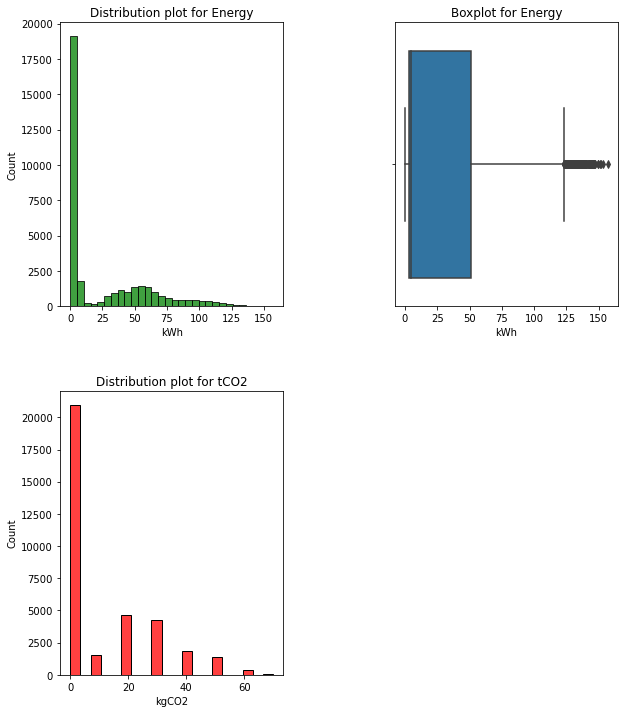

In [19]:
fig = plt.figure(figsize=(10,12)) #Create the figure for all the subplots
ax1 = fig.add_subplot(221) #Give each subplot a set within the grid
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

#Create the subplots
sns.histplot(df['usage_kwh'], color='g', bins=30, ax= ax1)  
sns.boxplot(x=df['usage_kwh'], ax=ax2)
sns.histplot(df['kgco2'], color = 'r', bins = 20, ax=ax3)

#General subplot spacing
plt.subplots_adjust(wspace=0.5, hspace=0.3)

#Individual subplot labels and format
ax1.set_title("Distribution plot for Energy")
ax1.set_xlabel("kWh")

ax2.set_title("Boxplot for Energy")
ax2.set_xlabel("kWh")

ax3.set_title("Distribution plot for tCO2")
ax3.set_xlabel("kgCO2")


- Distribution plot for energy
    - Not useful since most is centered at 0 when machinery is not in use, its not considered an outlier since 0 kWh is still a valid measure of electricity and is possible to measure (meaning the machine is turned off)
    - Very rarely are the machinery used in their maximum outputs, they operate under nominal values most of the time
    
- Boxplot for energy
    - Most data is clustered in the 0 to 50 kWh range with some very few values with high kWh
    
- Distributinon plot kg CO2
    - Most data will coincide with the energy distribution plot since both are very correlated and if no energy is being used then no CO2 is being produced

### Scatter plot Energy vs. Hours of day

[Text(0.5, 1.0, 'Energy vs. Hours of day'),
 Text(0.5, 0, 'Time of day'),
 Text(0, 0.5, 'Energy [kWh]')]

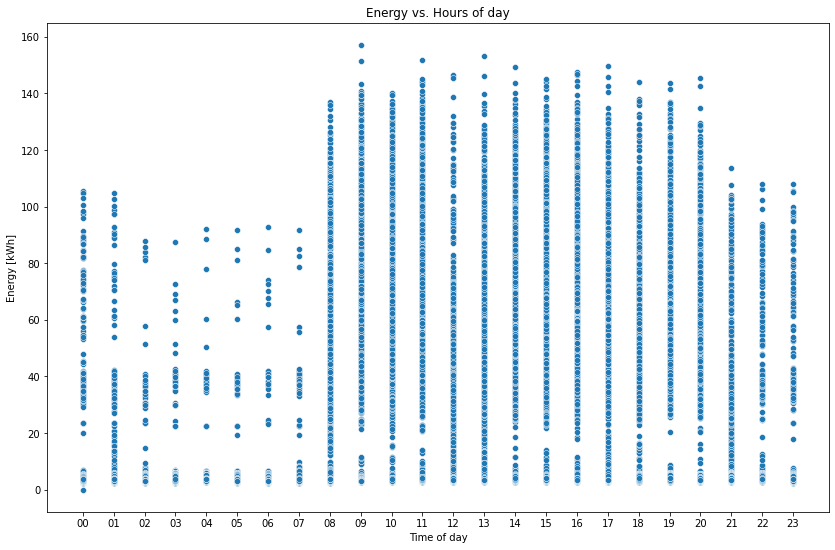

In [20]:
fig = plt.figure(figsize=(14,9))

sns.scatterplot(x=df.hour, y=df.usage_kwh).set(title= "Energy vs. Hours of day", xlabel = "Time of day", ylabel= "Energy [kWh]")

**Observations**

It can be clearly seen that most of the data is clustered in typical working business hours which in this case seems to be 8 a.m. to 8 p.m.

### Scatter plot Energy vs. Month

[Text(0.5, 1.0, 'Energy vs. Months'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Energy [kWh]')]

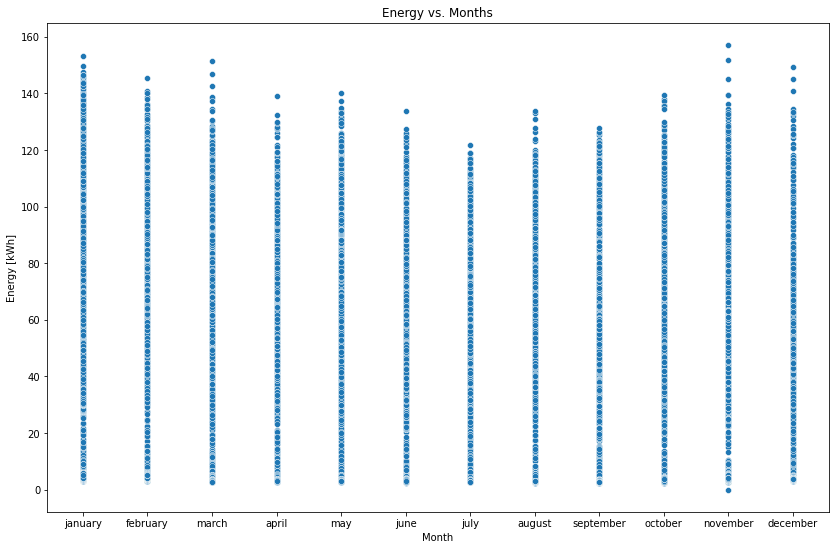

In [21]:
fig = plt.figure(figsize=(14,9))

sns.scatterplot(x=df.month, y=df.usage_kwh).set(title= "Energy vs. Months", xlabel = "Month", ylabel= "Energy [kWh]")

**Observations**

Energy usage does not vary to much between months meaning that that mught not be a decisive factor for a good prediction, this feature will be omitted for the model creation

### Scatter plot for Energy vs Days of the month

[Text(0.5, 1.0, 'Energy vs. Day'),
 Text(0.5, 0, 'Day'),
 Text(0, 0.5, 'Energy [kWh]')]

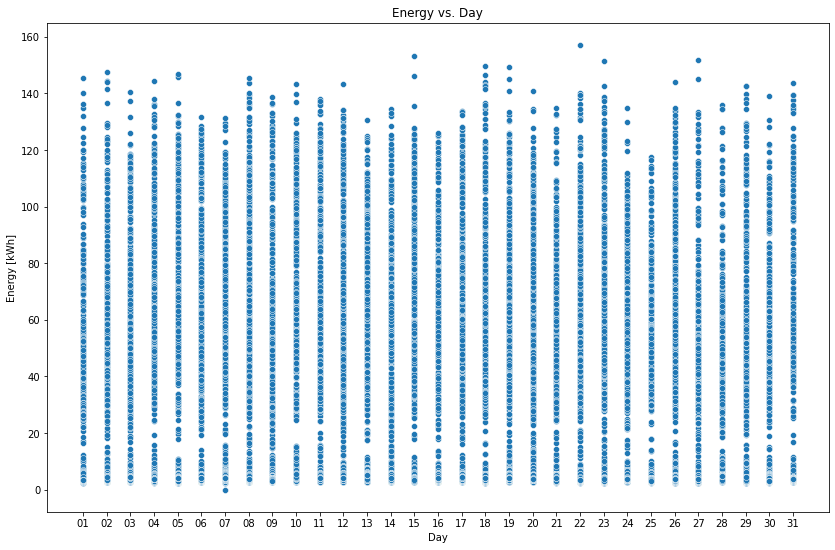

In [22]:
fig = plt.figure(figsize=(14,9))

sns.scatterplot(x=df.day, y=df.usage_kwh).set(title= "Energy vs. Day", xlabel = "Day", ylabel= "Energy [kWh]")

**Observations**


Day does not appear to affect the energy consumed, I was looking for increases at certain days of the factory however the factory production does not appear to be so reactive and has a steady production though the days of the month. 

There is not much point in having the day feature since we already have a Weekstatus and the day_of_week columns, therefore day will be dropped.

[Text(0.5, 1.0, 'Energy vs. Day of week'),
 Text(0.5, 0, 'Day of Week'),
 Text(0, 0.5, 'Energy [kWh]')]

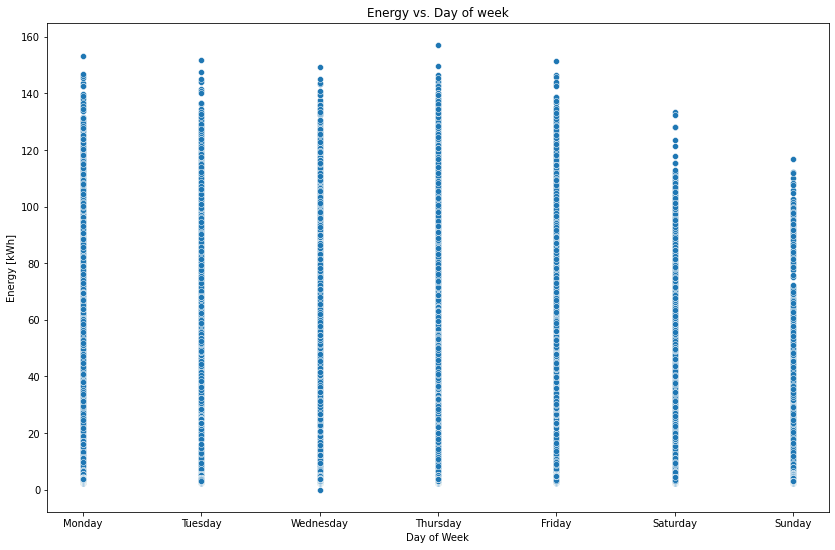

In [23]:
fig = plt.figure(figsize=(14,9))

sns.scatterplot(x=df.day_of_week, y=df.usage_kwh).set(title= "Energy vs. Day of week", xlabel = "Day of Week", ylabel= "Energy [kWh]")

In [24]:
df.drop(['day', 'month'], inplace=True, axis=1)

### Energy vs Power Factors

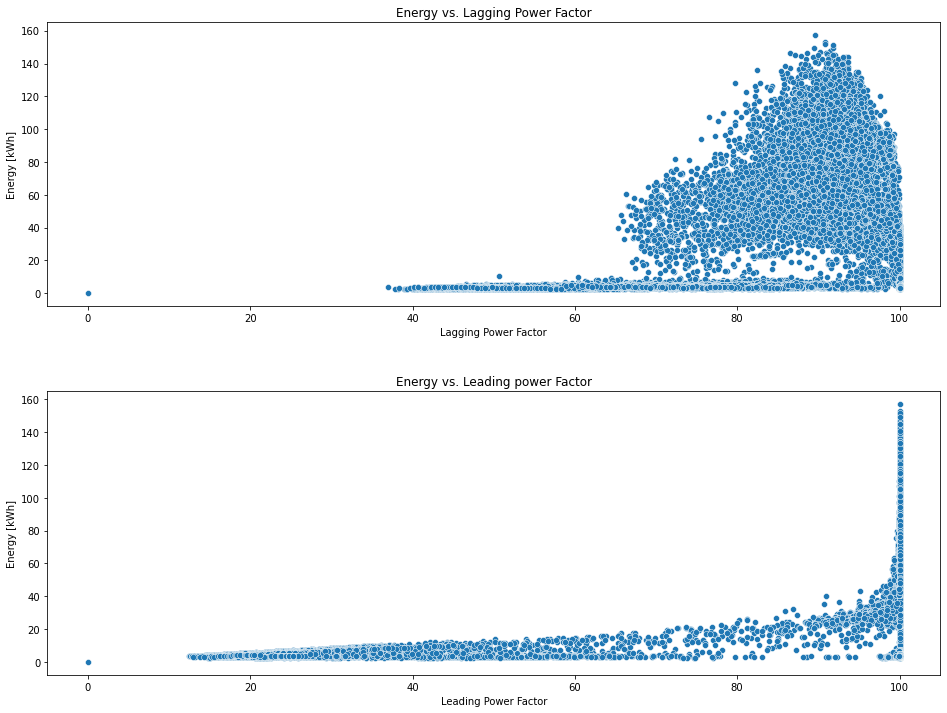

In [25]:
fig = plt.figure(figsize=(16,12)) #Create the figure for all the subplots
ax1 = fig.add_subplot(211) #Give each subplot a set within the grid
ax2 = fig.add_subplot(212)

#Create the subplots
sns.scatterplot(x=df.lagging_pf, y=df.usage_kwh, ax=ax1).set(title= "Energy vs. Lagging Power Factor", xlabel = "Lagging Power Factor", ylabel= "Energy [kWh]")
sns.scatterplot(x=df.leading_pf, y=df.usage_kwh, ax=ax2).set(title= "Energy vs. Leading power Factor", xlabel = "Leading Power Factor", ylabel= "Energy [kWh]")

#General subplot spacing
plt.subplots_adjust(wspace=0.5, hspace=0.3)

**Observations**

**Lagging Power factor vs Energy**
- Values for lagging power factor start in the range of 40 and the energy obtained does not seem linear meaning we can get more energy out of lower power factors not only from 100. 

**Leading Power factor vs Energy**
- The relationship here seems to be an exponential relationship, meaning the higher the power factor the higher the 'active' energy output. 

**Comparisson**

- Notice the energy between difference when power factors drop. There is still some useful energy obtained when we see the Lagging power factor compared to the energy in the leading power factor. 

- This is because most probably, the machinery in the steel production here is mostly machinery that produces a lagging power factor. Measures most have been made to compensate for the power factor, most commmonly used are capacitor banks. These capacitor banck regulate the power factor so that more 'active' power can be obtained and the power factor penalizations are not met which in the enrgy industry tend to be quite steep in price. 


This makes an important point, 'active' energy greatly depends on the power factor, however we can see here that the tendency of the machinery in the steel factory tend to produce a lagging factor resulting from an inductive load. Correlation to the lagging factor will be affected since most probably an external factor has been implemented to compensate for the power factor and get more energy.

In [26]:
#One last revision of the dataframe
df

,usage_kwh,lagging_kvarh,leading_kvarh,lagging_pf,leading_pf,weekstatus,day_of_week,load_type,kgco2,hour
0,3.17,2.95,0.00,73.21,100.00,Weekday,Monday,Light_Load,0.0,00
1,4.00,4.46,0.00,66.77,100.00,Weekday,Monday,Light_Load,0.0,00
2,3.24,3.28,0.00,70.28,100.00,Weekday,Monday,Light_Load,0.0,00
3,3.31,3.56,0.00,68.09,100.00,Weekday,Monday,Light_Load,0.0,01
4,3.82,4.50,0.00,64.72,100.00,Weekday,Monday,Light_Load,0.0,01
...,...,...,...,...,...,...,...,...,...,...
35035,3.85,4.86,0.00,62.10,100.00,Weekday,Monday,Light_Load,0.0,23
35036,3.74,3.74,0.00,70.71,100.00,Weekday,Monday,Light_Load,0.0,23
35037,3.78,3.17,0.07,76.62,99.98,Weekday,Monday,Light_Load,0.0,23
35038,3.78,3.06,0.11,77.72,99.96,Weekday,Monday,Light_Load,0.0,23


### Data transformation

In [27]:
#Call for functions file
%run Functions_ER.ipynb 

#Create the dummified dataframe
df_dummies = make_dummies(df)
df_dummies

,usage_kwh,lagging_kvarh,leading_kvarh,lagging_pf,leading_pf,kgco2,Weekend,Monday,Saturday,Sunday,...,14,15,16,17,18,19,20,21,22,23
0,3.17,2.95,0.00,73.21,100.00,0.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.00,4.46,0.00,66.77,100.00,0.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.24,3.28,0.00,70.28,100.00,0.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.31,3.56,0.00,68.09,100.00,0.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.82,4.50,0.00,64.72,100.00,0.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,3.85,4.86,0.00,62.10,100.00,0.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
35036,3.74,3.74,0.00,70.71,100.00,0.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
35037,3.78,3.17,0.07,76.62,99.98,0.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
35038,3.78,3.06,0.11,77.72,99.96,0.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [28]:
#Change all column names into lowercase
df_dummies.columns = df_dummies.columns.str.lower() 

## Save the cleaned dataframe

In [29]:
#Remove the index
df_dummies.to_csv('datasets/cleaned_steel_industry.csv', index=False)

## Hypothesis

- Predictions will be good since energy has good correlation with most of the columns in the dataframe

- Feature selection can be still further inplemented and can help the score perform better

- If predictions are not good the following can still be made: 

    - Define normal business hours as a new column and if between 8 am and 19 then 1 if not 0

    - For training and testing, model could be better trained if values at 0 were not included in the training data if the testing also donesn't include data

# Model creation and predictions

## e. Prepare the features and target variable

In [30]:
#Define the target and split into train and test

target = df_dummies.usage_kwh
df_dummies.drop('usage_kwh', inplace=True, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(df_dummies, target, random_state=42, test_size=0.25)

In [31]:
#Names for models to use as classifiers

names = [
    "Linear Regression",
    "Decision Tree Regressor",
    "Random Forest Regressor",
    "AdaBoost Regressor",
    "XGBoost Regressor",
    "CatBoost Regressor", 
    "LightGBM Regressor", 
    "SGD Regressor"
]

scores = []

#Classifiers to use with various parameters (These were tested with different parameters)

clf = [
    LinearRegression(),
    DecisionTreeRegressor(max_depth=None, random_state=42, max_leaf_nodes=10),
    RandomForestRegressor(n_estimators=200, verbose=False),
    AdaBoostRegressor(n_estimators=200),
    XGBRegressor(n_estimators=200, max_depth=5), 
    CatBoostRegressor(learning_rate=0.01, depth=5, verbose=False, n_estimators=200), 
    LGBMRegressor(boosting_type='gbdt', max_depth=5, learning_rate=0.01, n_estimators=200), 
    SGDRegressor(loss='squared_error', max_iter=2000)
]

#MinMax had the best results followed by Robust and Standard

for model in clf:
    pipe = Pipeline([("scaler", StandardScaler()),
                     ('selector', SelectFromModel(estimator=RandomForestRegressor(n_estimators=200))),
                     ("classifier", model)])
    
    
    pipe.fit(X_train, Y_train)
    print(model)
    score = pipe.score(X_test, Y_test)
    scores.append(score)
    print("Model score: %.3f" %score)
    print("\n-------------------------\n")

#Save everything into a dataframe    
scores_df = pd.DataFrame(zip(names,scores), columns=['Classifier', 'Accuracy'])

LinearRegression()
Model score: 0.983

-------------------------

DecisionTreeRegressor(max_leaf_nodes=10, random_state=42)
Model score: 0.984

-------------------------

RandomForestRegressor(n_estimators=200, verbose=False)
Model score: 0.984

-------------------------

AdaBoostRegressor(n_estimators=200)
Model score: 0.972

-------------------------

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
Model score: 0.

All models perform with very good scores.

## Perform enhanced modeling in selected model

I'll select linear regression as the model I want to implement and will try to improve the score as much as possible. I will perform the follwing: 

- Feature selection with SelectKBest, Correlation and variance Threshold
- Scaling 
- Polinomial fitting
- Perform Lasso Regression

I will then compare results with previous models and display those in a dataframe

In [32]:
#Reload the cleaned dataset from scratch to avoid mixing
df_dummies = pd.read_csv('datasets/cleaned_steel_industry.csv')
target = df_dummies.usage_kwh

### Correlation 

In [33]:
#Calculate the correlations for the whole dataframe
df_dummies.corr().abs().sort_values(by='usage_kwh', ascending=False).loc[:, 'usage_kwh'] 

usage_kwh        1.000000
kgco2            0.988180
lagging_kvarh    0.896150
maximum_load     0.487792
lagging_pf       0.385960
leading_pf       0.353566
leading_kvarh    0.324922
weekend          0.295475
sunday           0.241814
medium_load      0.204521
09               0.194305
11               0.185238
14               0.179364
10               0.177615
16               0.177146
15               0.176136
06               0.144417
05               0.144281
04               0.143882
03               0.143579
02               0.143141
07               0.142681
saturday         0.139764
01               0.132890
23               0.120885
22               0.116764
17               0.102538
thursday         0.094150
tuesday          0.085808
21               0.084852
13               0.072526
monday           0.070948
19               0.067470
08               0.064330
20               0.062911
wednesday        0.059320
12               0.055651
18               0.035127
Name: usage_

There are very few features that have good correlation, I'll only select the ones above 0.20. 

In [34]:
#Manual selection for the correlation features
df_correlation = df_dummies[['kgco2',
                      'lagging_kvarh',
                      'maximum_load',
                      'lagging_pf', 
                      'leading_pf',
                      'leading_kvarh', 
                      'weekend', 
                        'sunday', 
                        'medium_load']]
df_correlation

,kgco2,lagging_kvarh,maximum_load,lagging_pf,leading_pf,leading_kvarh,weekend,sunday,medium_load
0,0.0,2.95,0,73.21,100.00,0.00,0,0,0
1,0.0,4.46,0,66.77,100.00,0.00,0,0,0
2,0.0,3.28,0,70.28,100.00,0.00,0,0,0
3,0.0,3.56,0,68.09,100.00,0.00,0,0,0
4,0.0,4.50,0,64.72,100.00,0.00,0,0,0
...,...,...,...,...,...,...,...,...,...
35035,0.0,4.86,0,62.10,100.00,0.00,0,0,0
35036,0.0,3.74,0,70.71,100.00,0.00,0,0,0
35037,0.0,3.17,0,76.62,99.98,0.07,0,0,0
35038,0.0,3.06,0,77.72,99.96,0.11,0,0,0


In [35]:
df_dummies.columns

Index(['usage_kwh', 'lagging_kvarh', 'leading_kvarh', 'lagging_pf',
       'leading_pf', 'kgco2', 'weekend', 'monday', 'saturday', 'sunday',
       'thursday', 'tuesday', 'wednesday', 'maximum_load', 'medium_load', '01',
       '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'],
      dtype='object')

### Variance Threshold selection

In [36]:
vt = VarianceThreshold(threshold=0.125) #Set the variance threshold
vt.fit(df_dummies)
vt_select = pd.DataFrame({'Variance': vt.variances_, 'select_status': vt.get_support()}, index=df_dummies.columns).sort_values(by='Variance', ascending=False)
cols = vt.get_support(indices=True) #Get the feature name columns for the variance threshold dataframe
df_vt = df_dummies.iloc[:, cols]
df_vt = df_vt.drop('usage_kwh', axis=1)
df_vt

,lagging_kvarh,leading_kvarh,lagging_pf,leading_pf,kgco2,weekend,maximum_load,medium_load
0,2.95,0.00,73.21,100.00,0.0,0,0,0
1,4.46,0.00,66.77,100.00,0.0,0,0,0
2,3.28,0.00,70.28,100.00,0.0,0,0,0
3,3.56,0.00,68.09,100.00,0.0,0,0,0
4,4.50,0.00,64.72,100.00,0.0,0,0,0
...,...,...,...,...,...,...,...,...
35035,4.86,0.00,62.10,100.00,0.0,0,0,0
35036,3.74,0.00,70.71,100.00,0.0,0,0,0
35037,3.17,0.07,76.62,99.98,0.0,0,0,0
35038,3.06,0.11,77.72,99.96,0.0,0,0,0


### Select K-Best

In [37]:
# Create and fit selector
select = SelectKBest(score_func=f_regression, k=10) #Apply k=10 for 10 features and with f_regression score function
df_dummies = df_dummies.drop('usage_kwh', axis=1)

select.fit_transform(df_dummies, target) 
cols = select.get_support(indices=True)
df_selKBest = df_dummies.iloc[:,cols] #Get the final dataframe
df_selKBest

,lagging_kvarh,leading_kvarh,lagging_pf,leading_pf,kgco2,weekend,sunday,maximum_load,medium_load,09
0,2.95,0.00,73.21,100.00,0.0,0,0,0,0,0
1,4.46,0.00,66.77,100.00,0.0,0,0,0,0,0
2,3.28,0.00,70.28,100.00,0.0,0,0,0,0,0
3,3.56,0.00,68.09,100.00,0.0,0,0,0,0,0
4,4.50,0.00,64.72,100.00,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
35035,4.86,0.00,62.10,100.00,0.0,0,0,0,0,0
35036,3.74,0.00,70.71,100.00,0.0,0,0,0,0,0
35037,3.17,0.07,76.62,99.98,0.0,0,0,0,0,0
35038,3.06,0.11,77.72,99.96,0.0,0,0,0,0,0


## Linear Regression Models with Feature Selection, Feature transformation and Scaling

In [38]:
#Creation of lists to use within loop
transformation = []
scaling = []
df_list = [df_dummies, df_correlation, df_vt, df_selKBest]
feature_selection = ["No Feature Selection", "No Feature Selection", "No Feature Selection", "No Feature Selection", 
                     "Correlation", "Correlation", "Correlation", "Correlation", 
                     "Variance", "Variance", "Variance", "Variance", 
                     "SelectKBest", "SelectKBest", "SelectKBest", "SelectKBest"]
rmse_scores = []
r2_scores = []

In [39]:
for df in df_list: 
    
    ln = LinearRegression() # Initialize the linear regression method
    iterations = []
    
    #No transformation or scaling
    iterations.append(df)
    transformation.append("None")
    scaling.append("None")
    
    #Transformation
    poly_df = make_poly(df) #Function to run transformation
    iterations.append(poly_df)
    transformation.append("Poly Degree 2")
    scaling.append("None")
    
    #Scaling
    scaled_df = make_scale(df) #Function to run scaling
    iterations.append(scaled_df)
    transformation.append("None")
    scaling.append("Standard Scaled")
    
    #Transofrmation ans scaling
    scaled_poly_df = make_scale(poly_df)
    iterations.append(scaled_poly_df)
    transformation.append("Poly Degree 2")
    scaling.append("Standard Scaled")
    
    for ite in iterations: 
        
        #Split the dataset into traning and testing data
        X_train, X_test, Y_train, Y_test = train_test_split(ite, target, test_size=0.25, random_state=42)

        ln.fit(X_train, Y_train)
    
        #Make the prediction
        Y_prediction = ln.predict(X_test)
        
        #Calculate R2 score and append
        r2 = ln.score(X_test, Y_test)
        r2_scores.append(r2)
        
        #Calculate RMSE score and append
        rmse = mean_squared_error(Y_test, Y_prediction, squared=False)
        rmse_scores.append(rmse)    

## Lasso Model

In [40]:
#Denote a series of alphas to try
alphas = np.linspace(1, 0.001, 25)
alphas

#split the model again into training and testing
xtrain, xtest, ytrain, ytest = train_test_split(df_dummies, target, test_size=0.25, random_state=42)

rmse_list_lasso = []
r2_list_lasso = []
model_list_lasso = []

#Run a loop for each of the alphas to see which one gets a better score
for a in alphas:
    lasso = Lasso(alpha=a, max_iter=1000)
    lasso.fit(xtrain, ytrain)
    pred = lasso.predict(xtest)
    
    r2_list_lasso.append(lasso.score(xtrain,ytrain))
    rmse_lasso = mean_squared_error(ytest, pred)**0.5;
    rmse_list_lasso.append(rmse_lasso)
    model_list_lasso.append(lasso)

#Get the RMSE scores sorted by minimum RMSE    
lasso_df = pd.DataFrame(zip(alphas, rmse_list_lasso, r2_list_lasso), columns=['Alpha', 'RMSE', "R2"])
lasso_sorted = lasso_df.sort_values(by=['RMSE', 'R2'], ascending=[True, False])
lasso_sorted.head(5)

,Alpha,RMSE,R2
23,0.042625,4.149767,0.979245
24,0.001000,4.151788,0.979673
22,0.084250,4.154472,0.979051
21,0.125875,4.172913,0.978783
20,0.167500,4.183159,0.978657


In [41]:
#Create table and add scores of linear models
scores_table = pd.DataFrame(data= {'Feature_Selection': feature_selection, 
                                   'Transformation':transformation, 
                                   'Scaling': scaling, 
                                  'R2': r2_scores, 
                                  'RMSE': rmse_scores})

lasso_alpha_str = "Lasso Alpha= " + str(lasso_sorted.Alpha.iloc[0])

#Add Lasso
scores_table = scores_table.append({'Feature_Selection': lasso_alpha_str, 
                                   'Transformation':"None", 
                                   'Scaling': "None", 
                                  'R2': lasso_sorted.R2.iloc[0], 
                                  'RMSE': lasso_sorted.RMSE.iloc[0]}, ignore_index=True)

In [42]:
scores_table.sort_values(by='R2', ascending=False) #Calculate the correlations for the whole dataframe

,Feature_Selection,Transformation,Scaling,R2,RMSE
1,No Feature Selection,Poly Degree 2,None,0.997153,1.795623
3,No Feature Selection,Poly Degree 2,Standard Scaled,0.997151,1.796080
5,Correlation,Poly Degree 2,None,0.996492,1.993153
7,Correlation,Poly Degree 2,Standard Scaled,0.996492,1.993194
13,SelectKBest,Poly Degree 2,None,0.996489,1.994083
15,SelectKBest,Poly Degree 2,Standard Scaled,0.996489,1.994083
9,Variance,Poly Degree 2,None,0.996486,1.994828
11,Variance,Poly Degree 2,Standard Scaled,0.996486,1.994828
2,No Feature Selection,None,Standard Scaled,0.984758,4.154567
0,No Feature Selection,None,None,0.984758,4.154571


**Best model obtained is from the No Feature Selection selection and the Second Degree Polynomial transormation. This is the one that will be used to do the predictions.**

## With no feature selection

In [43]:
#Create Scatter plot to compare actual vs. predicted

ln = LinearRegression()

#Transformation
poly_df = make_poly(df_dummies) #Function to run transformation

#split the model again into training and testing
xtrain, xtest, ytrain, ytest = train_test_split(poly_df, target, test_size=0.25, random_state=42)

ln.fit(xtrain, ytrain)   
pred = ln.predict(xtest)

#Calculate R2 score and append
r2 = ln.score(xtest, ytest)
print("R2 score is: ", r2) 

#Calculate RMSE score and append
rmse = mean_squared_error(ytest, pred, squared=False)
print("RMSE score is: ", rmse) 

R2 score is:  0.9971527534752661
RMSE score is:  1.7956234947029786


## Plot for predictions

Text(0.5, 1.0, 'Linear Regression Model with Second Degree Polynomial Transormation')

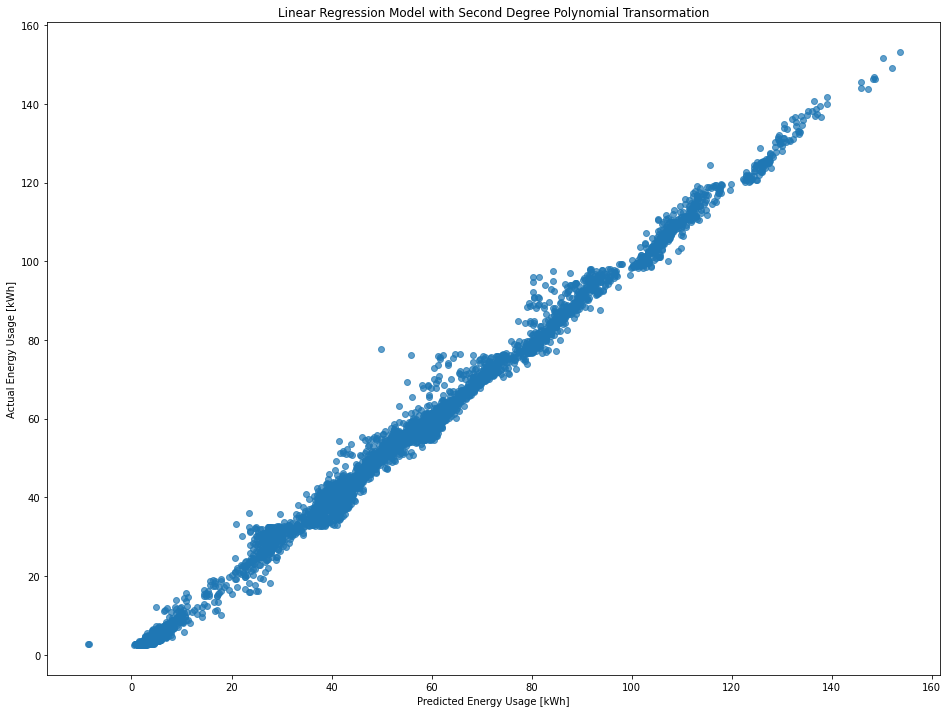

In [44]:
#Set figure and plot the predictions
fig = plt.figure(figsize=(16,12)) 
plt.scatter(pred, ytest, alpha=0.7)
plt.xlabel('Predicted Energy Usage [kWh]')
plt.ylabel('Actual Energy Usage [kWh]')
plt.title('Linear Regression Model with Second Degree Polynomial Transormation')

In [45]:
# the coefficient list
coef = ln.coef_.transpose()

#Calculate the correlations for the whole dataframe
pd.DataFrame(zip(X_train.columns, coef), columns=['feature', 'coef']).sort_values(
    by='coef', ascending=False) 

,feature,coef
17,lagging_kvarh maximum_load,105.587410
18,lagging_kvarh medium_load,82.261408
19,lagging_kvarh 09,53.649513
16,lagging_kvarh sunday,26.471268
15,lagging_kvarh weekend,25.713846
...,...,...
27,leading_kvarh medium_load,-53.991899
22,leading_kvarh leading_pf,-63.691117
23,leading_kvarh kgco2,-65.790198
30,lagging_pf leading_pf,-67.436684


**Observations**

- Surprisingly the biggest coefficients don't come from kgCO2 which has the highest correlation with the energy usage. 


- Lagging reactive power [kvarh] has much to do with an accurate prediction as most of the most positive coefficients belong to this power. Its interesting to know that the coefficients coincide with positive values while negative values point towards the power factor and lagging reactive power mostly. 


- Power factor, as hypothesised, has quite the impact on the prediction as seen with the coefficients. 


- The method that performed best was the one that used the most features out of all the datasets used and I believe that plays a high part into the prediction since it has more information to make an accurate. 
 
 
- A clear positive linear relationship can be seen in the prediction plot and the values predicted are very similar or on par with the test values inputted into the model which can be attested by the model accuracy score

- Too many features are needed to make a very accurate prediction, one would really have to consider the value of getting 0.99 as accuracy rather than sacrifice accuray over speed and work load on computing

## Out of Sample prediction

In [46]:
from IPython.display import display, HTML

synthetic = df_dummies.describe(percentiles=[0.75, 0.99]).loc[['75%', '50%'], :]
synthetic = synthetic.astype("int")

display(HTML(synthetic.to_html())) #To print the whole table columns

X_train, X_test, Y_train, Y_test = train_test_split(df_dummies, target, test_size=0.25, random_state=42)

ln.fit(X_train, Y_train)

    
#Make the prediction for synthetic
pred = ln.predict(synthetic)

,lagging_kvarh,leading_kvarh,lagging_pf,leading_pf,kgco2,weekend,monday,saturday,sunday,thursday,tuesday,wednesday,maximum_load,medium_load,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23
75%,22,2,99,100,20,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50%,5,0,87,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Tune the synthetic dataset so it makes sense

In [47]:
# Tune 50%
synthetic.loc['50%', 'monday'] = 1
synthetic.loc['50%', "08"] = 1
synthetic.loc['50%', 'maximum_load'] = 1
synthetic.loc['50%', 'kgco2'] = 60
synthetic.loc['50%', 'lagging_kvarh'] = 62
synthetic.loc['50%', 'leading_kvarh'] = 26

#Tune 75%
synthetic.loc['75%', 'saturday'] = 1
synthetic.loc['75%', '19'] = 1

display(HTML(synthetic.to_html()))

,lagging_kvarh,leading_kvarh,lagging_pf,leading_pf,kgco2,weekend,monday,saturday,sunday,thursday,tuesday,wednesday,maximum_load,medium_load,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23
75%,22,2,99,100,20,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
50%,62,26,87,100,60,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [48]:
#Get the last predictions for out of sample data
prediction = ln.predict(synthetic)
prediction

array([ 49.24666855, 122.33492587])

The out of prediction was succesfull, in this case I used the 50 and 75 percetile of data as a reference and modified it to fit to my convenience looking for the data that would get get closer to 'real world' data.

No negative values or strange predictions obtained, the prediction that had medium load and lower values of kvarh had a lesser usage than the other that had a maximum load and higher values for reactive energy. 